# Find practices with similar demographic shapes

In [158]:
import matplotlib.pyplot as plt     
import seaborn as sns   

MIN_LIST_SIZE = 5000  # Don't consider any practice smaller than this for similarity
target = "E85124"     # GP At Hand


%matplotlib inline
sns.set_style("white")

bands = ['0_4', '5_14', '15_24',
       '25_34', '35_44', '45_54', '55_64', '65_74',
       '75_plus']

In [21]:
def pyramid(full_df, code, month=None):
    df = full_df[full_df['practice_id'] == code]
    # put male on left
    for band in bands:
        df["xmale_" + band] = 0 - df["male_" + band]
    # plot every year in turn - write to file so we can animate
    if month:
        months = [month]
    else:
        months = sorted(df.month)
    for i, month in enumerate(months):
        plt.figure(i)
        df1 = df[df['date'] == month]
        df2 = pd.DataFrame(columns=['male', 'female'])
        #df2.columns = []
        for band in bands:
            df2.loc[band] = [df1["xmale_" + band].iloc[0], df1["female_" + band].iloc[0]]
        df2 = df2.reset_index()
        malemax = df2['male'].min() * -1.1
        plt.xlim(-malemax, malemax)
        sns.set_color_codes("pastel")
        bar_plot = sns.barplot(x="male", y="index", color="blue", label="male",data = df2)
        bar_plot = sns.barplot(x="female", y="index", color="red", label="female",data = df2)
        plt.show()
        # uncomment to save files for animation
        #plt.savefig('/tmp/myfig_%s.png' % month.strftime("%Y-%m-%d"))

In [159]:
import pandas as pd

df = pd.read_csv("stats.csv", usecols=['date', 'male_0_4', 'female_0_4', 'male_5_14', 'female_5_14',
       'male_15_24', 'female_15_24', 'male_25_34', 'female_25_34',
       'male_35_44', 'female_35_44', 'male_45_54', 'female_45_54',
       'male_55_64', 'female_55_64', 'male_65_74', 'female_65_74',
       'male_75_plus', 'female_75_plus', 'total_list_size', 'pct_id', 'practice_id'])

ValueError: Usecols do not match columns, columns expected but not found: ['female_45_54', 'male_35_44', 'date', 'female_75_plus', 'pct_id', 'female_15_24', 'male_65_74', 'male_45_54', 'male_15_24', 'male_75_plus', 'male_0_4', 'female_5_14', 'female_0_4', 'male_25_34', 'female_35_44', 'female_25_34', 'female_55_64', 'male_55_64', 'total_list_size', 'practice_id', 'male_5_14', 'female_65_74']

In [164]:
df[df['date'] > '2018-01-03'].to_csv("/tmp/s.csv")

In [144]:
# slice the current date
df2 = df[df['date'] == '2018-09-01']
# invert values for males so we can plot on one chart
for band in bands:
    df2["xmale_" + band] = 0 - df2["male_" + band]

/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [146]:
df2

,date,male_0_4,female_0_4,male_5_14,female_5_14,male_15_24,female_15_24,male_25_34,female_25_34,male_35_44,...,practice_id,xmale_0_4,xmale_5_14,xmale_15_24,xmale_25_34,xmale_35_44,xmale_45_54,xmale_55_64,xmale_65_74,xmale_75_plus
411948,2018-09-01,251,230,495,503,1272,1303,1176,1258,951,...,E85680,-251,-495,-1272,-1176,-951,-533,-286,-179,-141
411949,2018-09-01,321,310,702,661,496,496,841,826,810,...,E85681,-321,-702,-496,-841,-810,-556,-336,-201,-132
419098,2018-09-01,212,203,601,573,534,482,544,501,551,...,E85682,-212,-601,-534,-544,-551,-501,-322,-165,-104
419099,2018-09-01,92,107,276,268,213,229,239,293,339,...,E85683,-92,-276,-213,-239,-339,-418,-303,-125,-86
426210,2018-09-01,108,108,231,240,217,238,248,248,252,...,A81001,-108,-231,-217,-248,-252,-261,-248,-228,-213
426211,2018-09-01,493,505,1086,1063,1049,980,1343,1314,1029,...,A81002,-493,-1086,-1049,-1343,-1029,-1372,-1444,-1091,-834
426212,2018-09-01,269,256,574,556,749,662,905,703,667,...,A81004,-269,-574,-749,-905,-667,-687,-676,-511,-387
426213,2018-09-01,184,168,432,435,331,341,405,404,442,...,A81005,-184,-432,-331,-405,-442,-548,-512,-614,-437
426214,2018-09-01,435,382,934,894,822,801,1001,1032,852,...,A81006,-435,-934,-822,-1001,-852,-999,-987,-713,-433
426215,2018-09-01,287,232,635,630,650,547,636,671,586,...,A81007,-287,-635,-650,-636,-586,-709,-620,-487,-343


In [150]:
cols_to_compare = ['male_' + x for x in bands]
cols_to_compare += ['female_' + x for x in bands]

def normalise(row):
    "normalise to proportion max value so numbers are comparable"
    mx = max(row)
    return [x/mx for x in row]


def ks2(row, target_data=None):  
    return scipy.stats.ks_2samp(target_data, normalise(row[cols_to_compare]))

target_data = normalise(df2[df2['practice_id'] == target][cols_to_compare].iloc[0])
ks = df2.apply(ks2, axis=1, target_data=target_data).apply(pd.Series)
ks.columns = ['ks2', 'ks2_p']
df3 = df2.join(ks).sort_values('ks2')

In [153]:
# Filter for similarity
df4 = df3[(df3['ks2_p'] > 0.1) & (df3['total_list_size'] > MIN_LIST_SIZE)]

In [154]:
df4[['total_list_size', 'practice_id', 'ks2', 'ks2_p']].head()

,total_list_size,practice_id,ks2,ks2_p
428407,32569,E85124,0.000000,1.000000
428930,9264,F83672,0.111111,0.999685
430370,19114,J82199,0.111111,0.999685
427454,38695,C84023,0.166667,0.944753
428554,15065,E87677,0.222222,0.708768


In [156]:
practices = df2.join(df4[['ks2', 'ks2_p']], how='inner').sort_values('ks2')['practice_id']

E85124


/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


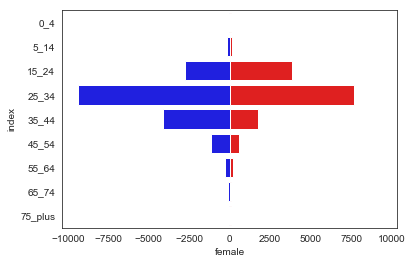

F83672


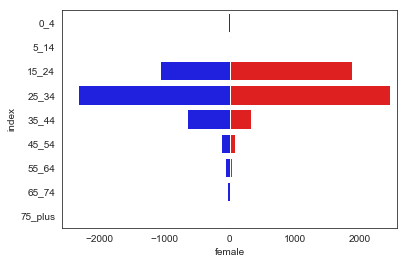

J82199


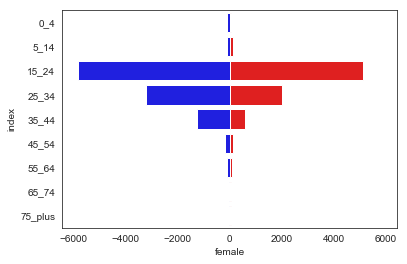

C84023


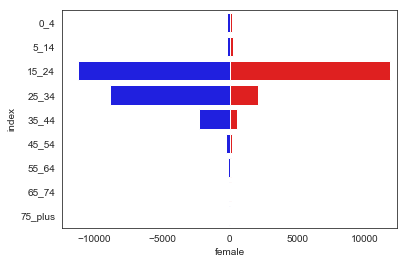

B83051


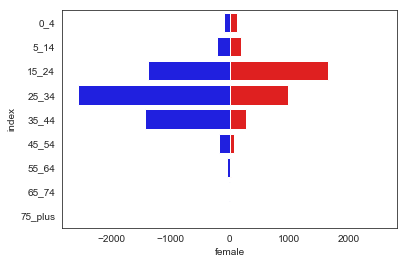

D82088


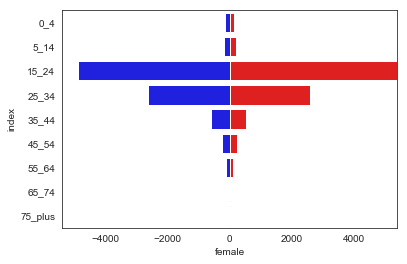

In [157]:
for practice in practices[0:6]:
    print(practice)
    pyramid(df, practice, '2018-09-01')